In [24]:
!pip install transformers
!pip install evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


# 0. Preprocessing

In [25]:
import pandas as pd
import numpy as np
import evaluate
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from datasets import Dataset
import torch
from sklearn import metrics
import re

In [26]:
df = pd.read_csv("/kaggle/input/bert-fine-tune-data/datasetSentences.txt", sep="\t", index_col=0)

dictionary = pd.read_csv("/kaggle/input/bert-fine-tune-data/dictionary.txt", sep="|", index_col=1, header=None)

label = pd.read_csv("/kaggle/input/bert-fine-tune-data/sentiment_labels.txt", sep="|", index_col=0)

dataset_split = pd.read_csv("/kaggle/input/traintest/datasetSplit.txt", index_col=0)

In [27]:
df = pd.merge(df,dataset_split, left_index=True,right_index=True)
df

,sentence,splitset_label
sentence_index,,
1,The Rock is destined to be the 21st Century 's...,1
2,The gorgeously elaborate continuation of `` Th...,1
3,Effective but too-tepid biopic,2
4,If you sometimes like to go to the movies to h...,2
5,"Emerges as something rare , an issue movie tha...",2
...,...,...
11851,A real snooze .,1
11852,No surprises .,1
11853,We 've seen the hippie-turned-yuppie plot befo...,1


In [28]:
df_test = df.copy()
df_test = df_test[df_test['splitset_label'] == 2]
df_test = df_test.reset_index(drop=True)
df_test

,sentence,splitset_label
0,Effective but too-tepid biopic,2
1,If you sometimes like to go to the movies to h...,2
2,"Emerges as something rare , an issue movie tha...",2
3,The film provides some great insight into the ...,2
4,Offers that rare combination of entertainment ...,2
...,...,...
2205,An imaginative comedy\/thriller .,2
2206,"-LRB- A -RRB- rare , beautiful film .",2
2207,-LRB- An -RRB- hilarious romantic comedy .,2
2208,Never -LRB- sinks -RRB- into exploitation .,2


In [29]:
df_train = df.copy()
df_train = df_train[df_train['splitset_label'] == 1]
df_train = df_train.reset_index(drop=True)
df_train

,sentence,splitset_label
0,The Rock is destined to be the 21st Century 's...,1
1,The gorgeously elaborate continuation of `` Th...,1
2,Singer\/composer Bryan Adams contributes a sle...,1
3,You 'd think by now America would have had eno...,1
4,Yet the act is still charming here .,1
...,...,...
8539,A real snooze .,1
8540,No surprises .,1
8541,We 've seen the hippie-turned-yuppie plot befo...,1
8542,Her fans walked out muttering words like `` ho...,1


In [30]:
test_file_path = '/kaggle/input/traintest/test.txt'
train_file_path = '/kaggle/input/traintest/train.txt'

In [31]:
# Initialize an empty list to store the first numbers
test_first_numbers = []

# Open the file and read it line by line
with open(test_file_path, 'r') as file:
    for line in file:
        # Find the first occurrence of a number in each line
        match = re.search(r'\d+', line)
        if match:
            # Append the found number to the list
            test_first_numbers.append(int(match.group()))
labels_test = pd.DataFrame(test_first_numbers, columns=['sentiment_labels'])
print(labels_test)
df_test = pd.merge(df_test,labels_test, left_index=True,right_index=True)
df_test

      sentiment_labels
0                    2
1                    3
2                    4
3                    2
4                    4
...                ...
2205                 3
2206                 4
2207                 4
2208                 3
2209                 0

[2210 rows x 1 columns]


,sentence,splitset_label,sentiment_labels
0,Effective but too-tepid biopic,2,2
1,If you sometimes like to go to the movies to h...,2,3
2,"Emerges as something rare , an issue movie tha...",2,4
3,The film provides some great insight into the ...,2,2
4,Offers that rare combination of entertainment ...,2,4
...,...,...,...
2205,An imaginative comedy\/thriller .,2,3
2206,"-LRB- A -RRB- rare , beautiful film .",2,4
2207,-LRB- An -RRB- hilarious romantic comedy .,2,4
2208,Never -LRB- sinks -RRB- into exploitation .,2,3


In [32]:
# Initialize an empty list to store the first numbers
train_first_numbers = []

# Open the file and read it line by line
with open(train_file_path, 'r') as file:
    for line in file:
        # Find the first occurrence of a number in each line
        match = re.search(r'\d+', line)
        if match:
            # Append the found number to the list
            train_first_numbers.append(int(match.group()))
labels_train = pd.DataFrame(train_first_numbers, columns=['sentiment_labels'])
print(labels_train)
df_train = pd.merge(df_train,labels_train, left_index=True,right_index=True)
df_train

      sentiment_labels
0                    3
1                    4
2                    3
3                    2
4                    3
...                ...
8539                 0
8540                 1
8541                 3
8542                 0
8543                 1

[8544 rows x 1 columns]


,sentence,splitset_label,sentiment_labels
0,The Rock is destined to be the 21st Century 's...,1,3
1,The gorgeously elaborate continuation of `` Th...,1,4
2,Singer\/composer Bryan Adams contributes a sle...,1,3
3,You 'd think by now America would have had eno...,1,2
4,Yet the act is still charming here .,1,3
...,...,...,...
8539,A real snooze .,1,0
8540,No surprises .,1,1
8541,We 've seen the hippie-turned-yuppie plot befo...,1,3
8542,Her fans walked out muttering words like `` ho...,1,0


In [33]:
dictionary = dictionary.sort_index()
dictionary

,0
1,
0,!
1,'
2,' (
3,' ( the cockettes
4,' ( the cockettes )
...,...
239227,your standard Hollywood bio-pic
239228,your typical ` fish out of water ' story
239229,zero .


In [34]:
data = pd.merge(dictionary, label, left_index=True, right_index=True)
data

,0,sentiment values
1,,
0,!,0.50000
1,',0.50000
2,' (,0.44444
3,' ( the cockettes,0.50000
4,' ( the cockettes ),0.42708
...,...,...
239227,your standard Hollywood bio-pic,0.36111
239228,your typical ` fish out of water ' story,0.38889
239229,zero .,0.33333


In [35]:
# transform it to a dictionary with 'label and 'text'
data = data.reset_index()
data = data.rename(columns={ 0:'text', 'sentiment values':'label'})
data = data.drop(1, axis=1)
data = data[['label', 'text']]
data = data.dropna()

# 1. Fine-tuning on 5 separated classes

In [36]:
#change the label to 5 classes 0-0.2 for 0, 0.2-0.4 for 1, 0.4-0.6 for 2, 0.6-0.8 for 3, 0.8-1 for 4
#change the label to 5 classes 0-0.2 for 0, 0.2-0.4 for 1, 0.4-0.6 for 2, 0.6-0.8 for 3, 0.8-1 for 4
def change_label(x):
    if x <= 0.2:
        return 0
    elif x <= 0.4:
        return 1
    elif x <= 0.6:
        return 2
    elif x <= 0.8:
        return 3
    else:
        return 4
data['label'] = data['label'].apply(change_label)
data['label'] = data['label'].dropna()
data['text'] = data['text'].dropna()
print(data)

        label                                      text
0           2                                         !
1           2                                         '
2           2                                       ' (
3           2                         ' ( the cockettes
4           2                       ' ( the cockettes )
...       ...                                       ...
239227      1           your standard Hollywood bio-pic
239228      1  your typical ` fish out of water ' story
239229      1                                    zero .
239230      4                         zippy jazzy score
239231      2                                       UNK

[239231 rows x 2 columns]


In [37]:
class_proportions = data['label'].value_counts()

print(class_proportions)
count_minority = len(data[data['label']==0])
concat =[
    data[data['label']==0],
    data[data['label'] == 1].sample(count_minority),
    data[data['label'] == 2].sample(count_minority),
    data[data['label'] == 3].sample(count_minority),
    data[data['label'] == 4].sample(count_minority)
]
data = pd.concat(concat)

class_proportions = data['label'].value_counts()
print(class_proportions)

data = data.sample(n=10000, random_state=42)

label
2    119448
3     50148
1     43028
4     15255
0     11352
Name: count, dtype: int64
label
0    11352
1    11352
2    11352
3    11352
4    11352
Name: count, dtype: int64


In [38]:
X= list(data['text'])
y= list(data['label'])
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2, random_state=42, stratify=y)
#X_train, X_test, y_train, y_test = list(df_train['sentence']), list(df_test['sentence']), train_first_numbers, test_first_numbers

# Check the distribution of classes in the splits
print("Training set:")
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Class {u}: {c} samples, {c/len(y_train)*100:.2f}%")

print("\nTest set:")
unique, counts = np.unique(y_test, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Class {u}: {c} samples, {c/len(y_test)*100:.2f}%")

Training set:
Class 0: 1618 samples, 20.23%
Class 1: 1568 samples, 19.60%
Class 2: 1582 samples, 19.78%
Class 3: 1604 samples, 20.05%
Class 4: 1628 samples, 20.35%

Test set:
Class 0: 404 samples, 20.20%
Class 1: 392 samples, 19.60%
Class 2: 396 samples, 19.80%
Class 3: 401 samples, 20.05%
Class 4: 407 samples, 20.35%


In [39]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

train_encodings = tokenizer(X_train, truncation=True,padding=True)
test_encodings = tokenizer(X_test,truncation=True,padding=True)

In [40]:
from datasets.dataset_dict import DatasetDict
from datasets import Dataset

train_dataset = Dataset.from_dict({"input_ids": train_encodings["input_ids"], "attention_mask": train_encodings["attention_mask"], "labels": y_train})
test_dataset = Dataset.from_dict({"input_ids": test_encodings["input_ids"], "attention_mask": test_encodings["attention_mask"], "labels": y_test})

In [41]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [43]:
training_args = TrainingArguments(
    output_dir="test_trainer", 
    evaluation_strategy="epoch", 
    num_train_epochs=10,     
)

In [44]:
trainer = Trainer(
    model=model, 
    args=training_args, 
    train_dataset=train_dataset, 
    eval_dataset=test_dataset, 
    compute_metrics=compute_metrics, 
)

In [45]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,1.147100,0.975156,0.576500
2,0.796100,1.078182,0.581500
3,0.543000,1.145731,0.572500
4,0.347300,1.366141,0.575500
5,0.221100,1.853887,0.590000
6,0.156300,2.254389,0.582500
7,0.085500,2.515438,0.584000
8,0.055900,2.805743,0.594000
9,0.032800,2.967619,0.591000
10,0.015300,3.048944,0.585500


Checkpoint destination directory test_trainer/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Checkpoint destination directory test_trainer/checkpoint-1000 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were sc

TrainOutput(global_step=5000, training_loss=0.34004270238876344, metrics={'train_runtime': 1277.3765, 'train_samples_per_second': 62.628, 'train_steps_per_second': 3.914, 'total_flos': 2672293634400000.0, 'train_loss': 0.34004270238876344, 'epoch': 10.0})

## 1.2 result

In [46]:
trainer.evaluate(test_dataset)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 3.0489439964294434,
 'eval_accuracy': 0.5855,
 'eval_runtime': 9.1831,
 'eval_samples_per_second': 217.792,
 'eval_steps_per_second': 13.612,
 'epoch': 10.0}

In [47]:
predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(-1)

# Get the true labels

# Create a DataFrame to compare the predicted and true labels
import pandas as pd
results = pd.DataFrame({
    'Predicted Label': predicted_labels,
    'True Label': y_test
})

print(results)


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


      Predicted Label  True Label
0                   1           0
1                   4           3
2                   1           1
3                   0           0
4                   1           2
...               ...         ...
1995                2           2
1996                1           0
1997                1           1
1998                1           0
1999                3           4

[2000 rows x 2 columns]


In [48]:
precision, recall, f1, _ = metrics.precision_recall_fscore_support(y_true=y_test, y_pred=predicted_labels, average='macro')
precision, recall, f1

(0.5904049290842304, 0.5846906507523352, 0.5862830968742292)

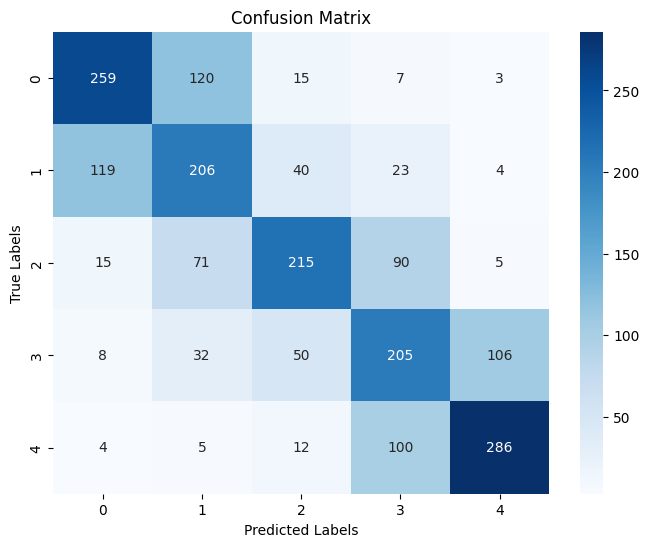

In [49]:
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
y_true = y_test
y_pred = predicted_labels

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

classes = [0,1,2,3,4]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# 2. Fine-tuning on 3 separated classes

In [50]:
#change the label to 3 classes 0-1 for 0, 2 for 1, 3-4 for 2
def change_label(x):
    if x <= 1:
        return 0
    elif x == 2:
        return 1
    else:
        return 2
data['label'] = data['label'].apply(change_label)
data['label'] = data['label'].dropna()
data['text'] = data['text'].dropna()

In [51]:
X= list(data['text'])
y= list(data['label'])
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2, random_state=42, stratify=y)
#X_train, X_test, y_train, y_test = list(df_train['sentence']), list(df_test['sentence']), train_first_numbers, test_first_numbers

# Check the distribution of classes in the splits
print("Training set:")
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Class {u}: {c} samples, {c/len(y_train)*100:.2f}%")

print("\nTest set:")
unique, counts = np.unique(y_test, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Class {u}: {c} samples, {c/len(y_test)*100:.2f}%")

Training set:
Class 0: 3186 samples, 39.83%
Class 1: 1582 samples, 19.78%
Class 2: 3232 samples, 40.40%

Test set:
Class 0: 796 samples, 39.80%
Class 1: 396 samples, 19.80%
Class 2: 808 samples, 40.40%


In [52]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

train_encodings = tokenizer(X_train, truncation=True,padding=True)
test_encodings = tokenizer(X_test,truncation=True,padding=True)

In [53]:
train_dataset = Dataset.from_dict({"input_ids": train_encodings["input_ids"], "attention_mask": train_encodings["attention_mask"], "labels": y_train})
test_dataset = Dataset.from_dict({"input_ids": test_encodings["input_ids"], "attention_mask": test_encodings["attention_mask"], "labels": y_test})

In [54]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [55]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [56]:
training_args = TrainingArguments(
    output_dir="test_trainer", 
    evaluation_strategy="epoch", 
    num_train_epochs=10,     
)

In [57]:
trainer = Trainer(
    model=model, 
    args=training_args, 
    train_dataset=train_dataset, 
    eval_dataset=test_dataset, 
    compute_metrics=compute_metrics, 
)

In [58]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.621400,0.584391,0.791000
2,0.374400,0.524480,0.798500
3,0.240700,0.680957,0.799500
4,0.162600,0.932027,0.797500
5,0.106500,1.110108,0.807000
6,0.059200,1.223815,0.794500
7,0.030200,1.430838,0.797500
8,0.018400,1.535667,0.800500
9,0.010400,1.631069,0.800000
10,0.002600,1.684472,0.797000


Checkpoint destination directory test_trainer/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Checkpoint destination directory test_trainer/checkpoint-1000 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were sc

TrainOutput(global_step=5000, training_loss=0.16264825232028962, metrics={'train_runtime': 1272.5201, 'train_samples_per_second': 62.867, 'train_steps_per_second': 3.929, 'total_flos': 2672245648800000.0, 'train_loss': 0.16264825232028962, 'epoch': 10.0})

## 2.1 results

In [59]:
trainer.evaluate(test_dataset)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 1.684471607208252,
 'eval_accuracy': 0.797,
 'eval_runtime': 8.8819,
 'eval_samples_per_second': 225.178,
 'eval_steps_per_second': 14.074,
 'epoch': 10.0}

In [60]:
predictions = trainer.predict(test_dataset)

predicted_labels = predictions.predictions.argmax(-1)

# Get the true labels

# Create a DataFrame to compare the predicted and true labels
import pandas as pd
results = pd.DataFrame({
    'Predicted Label': predicted_labels,
    'True Label': y_test
})

print(results)


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


      Predicted Label  True Label
0                   0           0
1                   2           2
2                   2           2
3                   0           0
4                   2           2
...               ...         ...
1995                2           2
1996                2           2
1997                0           0
1998                2           1
1999                1           1

[2000 rows x 2 columns]


In [61]:
precision, recall, f1, _ = metrics.precision_recall_fscore_support(y_true=y_test, y_pred=predicted_labels, average='macro')
precision, recall, f1

(0.7602392447324982, 0.7579005806778333, 0.758972206214323)

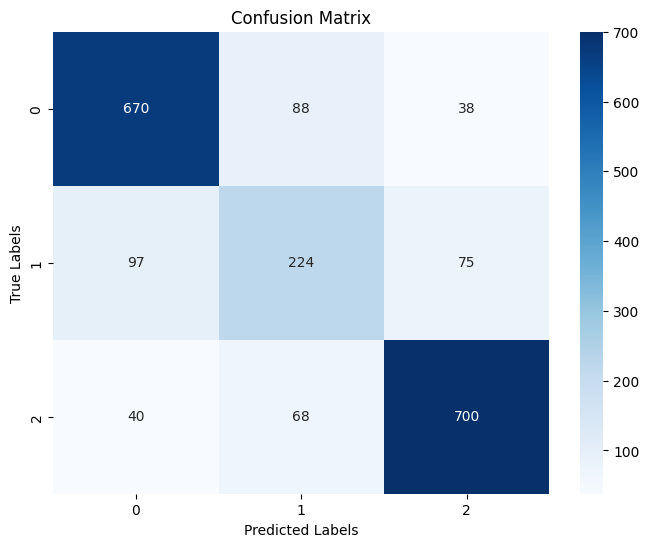

In [62]:
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
y_true = y_test
y_pred = predicted_labels

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

classes = [0,1,2]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()